In [50]:
import sys
import os
import requests
import datetime
from pathlib import Path
#
path_root = Path(os.path.abspath(''))
sys.path.insert(1, os.path.join(path_root))
#
path_root2 = Path(os.path.abspath('')).parent
sys.path.insert(1, os.path.join(path_root2))
import talib
import sqlite3 as sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from matplotlib import font_manager as fm, rcParams
from mplfinance.original_flavor import candlestick_ohlc
from util.util import get_ucodes
from scipy import stats

In [51]:
path_sqlite = os.path.join(path_root, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
if not os.path.exists(path_sqlite):
    path_sqlite = os.path.join(path_root2, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
print(path_sqlite)
conn = sqlite3.connect(path_sqlite)
cursor = conn.cursor()
conn.row_factory = lambda cursor, row: row[0]
start_date = '2020-06-01'
end_date = None

D:\PycharmProjects\scrapy-001\data\aastock\sqlite\hk-marketwatch.db


In [52]:
data1 = {}
data3 = {}
ucodes = ['hsi', 'hsce', 'hstech', 'ssec', 'csi300', 'sp500', 'dji', 'ixic']
ucodes = ['02800', '03033', '02823', '03188']
#ucodes = ['09988', '01810', '03690', '00700']
for ucode in ucodes:
    sql = """SELECT t.code, t.lot, t.nmll, t.stime, t.high, t.low, t.open, t.close, t.volume
                FROM (SELECT n.code, n.lot, n.nmll, c.stime, c.high, c.low, c.open, c.close, c.volume 
                    FROM s_{} AS c INNER JOIN name AS n 
                        ON c.code=n.code ORDER BY c.stime DESC) AS t 
                            ORDER BY t.stime """.format(ucode)
    cursor.execute(sql)
    columns = ['code', 'lot', 'nmll', 'sdate', 'high', 'low', 'open', 'last', 'vol']
    data1[ucode] = pd.DataFrame(cursor.fetchall(), columns=columns)
    data1[ucode].index = pd.to_datetime(data1[ucode].sdate)
    data1[ucode]['weekday'] = data1[ucode].index.dayofweek
    data1[ucode]['pchng'] = data1[ucode]['last'].pct_change()*100
    data3[ucode] = data1[ucode]
    if start_date:
        mask = (data1[ucode].index >= start_date)
        data1[ucode] = data1[ucode].loc[mask]
    if end_date:
        mask = (data1[ucode].index <= end_date)
        data1[ucode] = data1[ucode].loc[mask]
conn.close()

In [53]:
url = 's_hk' + ',s_hk'.join(ucodes)
res1 = requests.get('https://qt.gtimg.cn/q='+url).content.decode('gb2312')
res2 = "".join(res1.split()).strip()
for v1 in filter(None, res2.split('v_s_hk')):
    v2 = v1.split('~')
    print(v2)
    last = float(v2[3])
    ucode = v2[2]
    name = v2[1]
    sdate = datetime.datetime.now().strftime("%Y-%m-%d")
    vol = float(v2[6])
    df3 = pd.DataFrame([[None,None,name,sdate,None, None, None,last,vol,None,None]], columns=['code','lot','nmll','sdate','high','low','open','last','vol','weekday','pchng'])
    df3.index = pd.to_datetime(df3.sdate)
    df3['weekday'] = df3.index.dayofweek
    data1[ucode] = pd.concat([data1[ucode], df3])
    data1[ucode] = data1[ucode][~data1[ucode].index.duplicated(keep='last')]

['02800="100', '盈富基金', '02800', '29.640', '0.020', '0.07', '30504304.0', '905345956.370', '', '1029.3950";']
['03033="100', '南方恒生科技', '03033', '8.195', '0.035', '0.43', '25918060.0', '211992647.480', '', '0.0000";']
['02823="100', '安硕A50', '02823', '20.320', '-0.020', '-0.10', '3311638.0', '67176207.880', '', '261.3152";']
['03188="100', '华夏沪深三百', '03188', '64.280', '0.060', '0.09', '1459291.0', '93651548.020', '', '186.1870";']


In [54]:
no_spread = 30
data2 = {}
for ucode, df in data1.items():
    print('{}  {} ~ {}'.format(ucode, df.iloc[0].sdate, df.iloc[-1].sdate))
    data2[ucode] = pd.DataFrame(columns=['bottom', 'ceil', 'count', 'sdate', 'vol']) 
    max = df['last'].max()
    min = df['last'].min()
    spread = (max-min)/no_spread
    for i in range(0, no_spread):
        bottom = round(min + (spread*i), 2)
        ceil = round(min + (spread*(i+1)), 2)
        df2 = df.loc[(df['last'] >= bottom) & (df['last'] <= ceil)]
        count = df2.shape[0]
        sdate2 = df2['sdate'].values.tolist()
        vol = round(df.loc[(df['last'] >= bottom) & (df['last'] <= ceil)]['vol'].sum()/100000000, 3)
        data2[ucode].loc[len(data2[ucode])] = [bottom, ceil, count, ','.join(sdate2), vol]

02800  2020-06-01 ~ 2021-06-29
03033  2020-08-28 ~ 2021-06-29
02823  2020-06-01 ~ 2021-06-29
03188  2020-06-01 ~ 2021-06-29


,ucode,nmll,nobs,min,10%,20%,30%,40%,50%,mean,60%,70%,80%,90%,max,skewness,kurtosis,sd
0,02800,盈富基金,267,23.98,24.992,25.384,25.768,26.340,27.25,26.72,28.400,28.864,29.216,29.488,31.24,0.098822,-1.378187,1.865721
1,03033,南方恒生科技,205,6.94,7.468,7.654,7.881,7.950,8.22,8.06,8.150,8.294,8.576,9.606,10.92,1.261384,1.426098,0.785671
2,02823,安硕A50,267,14.09,16.216,16.812,17.252,18.238,18.70,19.21,19.530,19.814,20.640,21.248,23.62,-0.273035,-0.519528,2.119621
3,03188,华夏沪深三百,267,43.74,51.620,53.764,55.040,57.380,58.88,60.08,61.172,62.288,64.596,66.600,72.52,-0.437598,-0.228081,6.341237


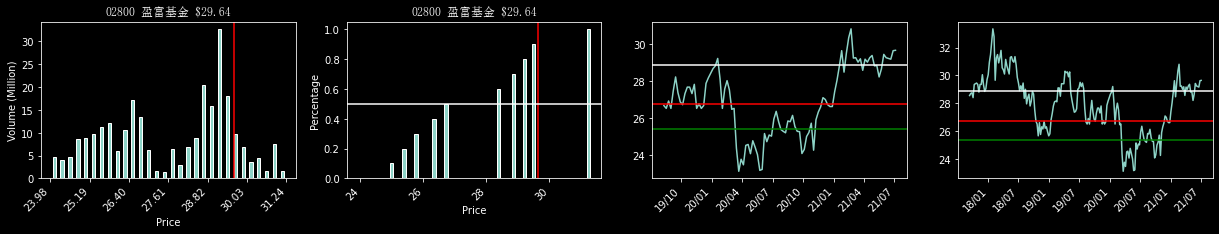

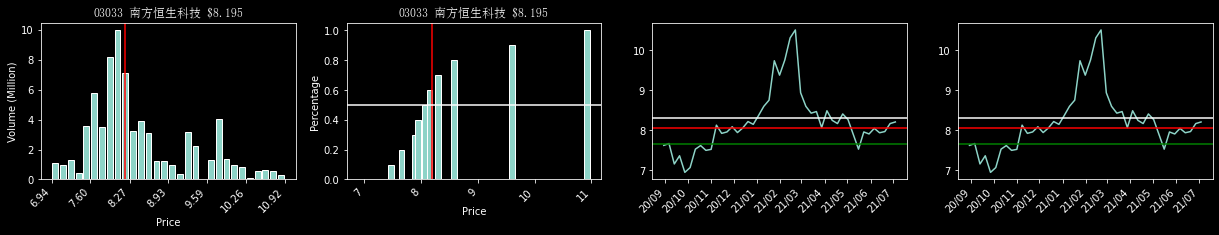

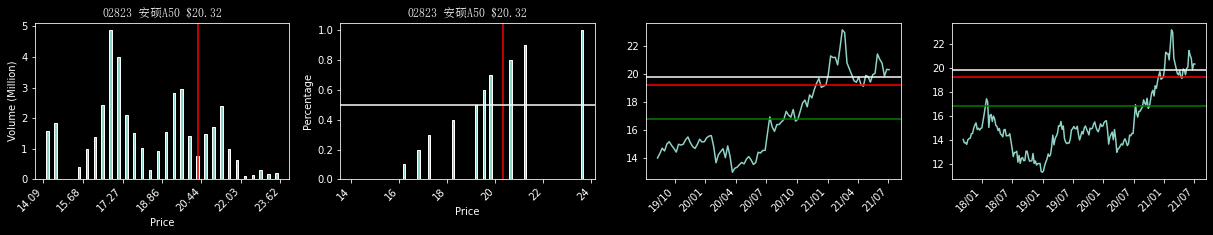

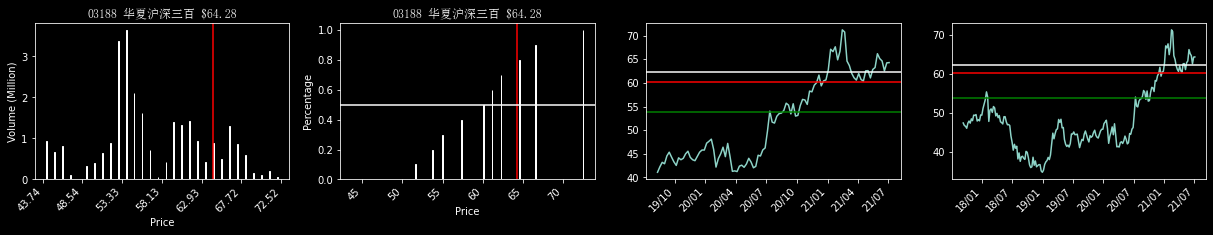

In [55]:
index = ['ucode', 'nmll', 'nobs', 'min', '10%', '20%', '30%', '40%', '50%', 'mean', '60%', '70%', '80%', '90%', 'max', 'skewness', 'kurtosis', 'sd']
fpath = os.path.join(rcParams["datapath"], "fonts/ttf/cmr10.ttf")
fpath = os.path.join('C:\Windows\Fonts', 'simsun.ttc')
prop = fm.FontProperties(fname=fpath)
fontsize = 12
df3 = pd.DataFrame(columns=index)
for ucode, df in data1.items():
    nmll = data1[ucode].iloc[-1]['nmll']
    d1 = stats.describe(df['last'].values)
    d2 = np.std(df['last'].values)
    d3_1 = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    d3 = df['last'].quantile(d3_1).values.tolist()
    d4 = pd.Series([ucode, nmll, d1.nobs, d1.minmax[0], d3[1], d3[2], d3[3], d3[4], round(d1.mean, 2), d3[5], d3[6], d3[7], d3[8], d3[9], d1.minmax[1], d1.skewness, d1.kurtosis, d2], index=index)
    df3 = df3.append(d4, ignore_index=True)
    
    '''
    plt.title(ucode+' '+nmll, fontproperties=prop, fontsize=fontsize)
    plt.xlabel('价格', fontproperties=prop, fontsize=fontsize)
    plt.ylabel('频率', fontproperties=prop, fontsize=fontsize)
    plt.style.use('dark_background')
    plt.hist(df['last'], width=0.1, bins=no_spread, ec='white')
    plt.show()
    '''
    '''
    plt.bar(df4['last'], height=df4['cum_vol'], width=0.1, ec='white', align='center')
    plt.title(ucode+' '+nmll, fontproperties=prop, fontsize=fontsize)
    plt.xlabel('价格', fontproperties=prop, fontsize=fontsize)
    plt.ylabel('亿手', fontproperties=prop, fontsize=fontsize)
    plt.style.use('dark_background')
    plt.show()
    '''
    
    df4 = pd.DataFrame(columns = ['last', 'cum_vol', 'count'])
    for k, v in data2[ucode].iterrows():
        df4_1 = pd.Series([(v['bottom']+v['ceil'])/2, v['vol'], v['count']], index=['last', 'cum_vol', 'count'])
        df4 = df4.append(df4_1, ignore_index=True)
    
    last = data1[ucode].iloc[-1]['last']
    yticks = np.linspace(df['last'].min(), df['last'].max(), num=7, endpoint=True)
    yticks = [round(x, 2) for x in yticks]
    title = ucode+' '+nmll+' $'+str(last)
    
    plt.style.use('dark_background')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(21, 3.2))
    fig.autofmt_xdate(rotation=45)
        
    ax1.bar(df4['last'], height=df4['cum_vol'], width=0.1, ec='white', align='center')
    ax1.set_title(title, fontproperties=prop, fontsize=fontsize)
    ax1.set(xlabel='Price', ylabel='Volume (Million)')
    ax1.axvline(last, color='r')
    ax1.set_xticks(yticks)
    
    ax2.bar(d3, d3_1, width=0.1, ec='white', align='center')
    ax2.set_title(title, fontproperties=prop, fontsize=fontsize)
    ax2.set(xlabel='Price', ylabel='Percentage')
    ax2.axvline(last, color='r')
    ax2.axhline(.5, color='w')
    
    week = data3[ucode].resample('W').agg({'open': 'first', 'high': 'max', 'low': 'min', 'last': 'last'})
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
    ax3.plot(week.tail(100).index, week.tail(100)['last'])
    ax3.axhline(d3[2], color='g')
    ax3.axhline(d3[5], color='r')
    ax3.axhline(d3[7], color='w')
    
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
    ax4.plot(week.tail(200).index, week.tail(200)['last'])
    ax4.axhline(d3[2], color='g')
    ax4.axhline(d3[5], color='r')
    ax4.axhline(d3[7], color='w')
df3

In [56]:
for ucode2, df2 in data2.items():
    row2 = data1[ucode2].iloc[-1]
    print(ucode2, row2['nmll'], row2['last'])
    df2["count"] = pd.to_numeric(df2["count"])
    n_larger = df2['vol'].nlargest(6).values.tolist()[::-1]
    spread = df2.iloc[0]['ceil'] - df2.iloc[0]['bottom']
    cum_vol = 0
    print('{}%  {}   {}'.format("{:.2f}".format(spread*10/row2['last']*100), 'aggr', 'nega'))
    for k, v in df2.iterrows():
        # 6大重倉標注
        remark = ''
        if v['vol'] in n_larger:
            remark = '<<'
            for i in range(0, n_larger.index(v['vol'])):
                remark += '--'
        # 現價
        remark2 = ''
        if row2['last'] >= v['bottom'] and row2['last'] < v['ceil']:
            remark2 = '现价'
        # 深度
        spread = v['ceil'] - v['bottom']
        p_bottom = spread/v['bottom']*100
        p_ceil = spread/v['ceil']*100
        # 分隔線
        if k%10 == 0 and k > 1:
            print('-------------------------------------------------')
        # 量1
        cum_vol += v['vol']
        remark3 = ''
        if str(k)[-1] == '9':
            remark3 = '('+str(round(cum_vol, 2))+'亿手)'
            cum_vol = 0
        #
        print('{}   | {}% ~ {}% | {} ~ {} | {}亿手 | {}  {} {} {}'.format(str(k+1).zfill(2), "{:.2f}".format(p_bottom), "{:.2f}".format(p_ceil), "{:.2f}".format(v['bottom']), "{:.2f}".format(v['ceil']), "{:.3f}".format(v['vol']), v['count'], remark, remark2, remark3))
    print('------------------------------------------------------------------')

02800 盈富基金 29.64
8.10%  aggr   nega
01   | 1.00% ~ 0.99% | 23.98 ~ 24.22 | 4.719亿手 | 5    
02   | 0.99% ~ 0.98% | 24.22 ~ 24.46 | 3.915亿手 | 4    
03   | 1.02% ~ 1.01% | 24.46 ~ 24.71 | 4.736亿手 | 6    
04   | 0.97% ~ 0.96% | 24.71 ~ 24.95 | 8.517亿手 | 11    
05   | 0.96% ~ 0.95% | 24.95 ~ 25.19 | 8.737亿手 | 14    
06   | 0.95% ~ 0.94% | 25.19 ~ 25.43 | 9.721亿手 | 16    
07   | 0.94% ~ 0.93% | 25.43 ~ 25.67 | 11.141亿手 | 18    
08   | 0.97% ~ 0.96% | 25.67 ~ 25.92 | 12.172亿手 | 19    
09   | 0.93% ~ 0.92% | 25.92 ~ 26.16 | 5.888亿手 | 9    
10   | 0.92% ~ 0.91% | 26.16 ~ 26.40 | 10.569亿手 | 13    (80.12亿手)
-------------------------------------------------
11   | 0.91% ~ 0.90% | 26.40 ~ 26.64 | 17.117亿手 | 20  <<----  
12   | 0.90% ~ 0.89% | 26.64 ~ 26.88 | 13.336亿手 | 14  <<  
13   | 0.93% ~ 0.92% | 26.88 ~ 27.13 | 6.304亿手 | 6    
14   | 0.88% ~ 0.88% | 27.13 ~ 27.37 | 1.542亿手 | 1    
15   | 0.88% ~ 0.87% | 27.37 ~ 27.61 | 1.406亿手 | 1    
16   | 0.87% ~ 0.86% | 27.61 ~ 27.85 | 6.486亿手 | 4    
17  